## Step 1: Loading Datasets

Combine the train and validation splits of the Common Voice 13 Dhivehi dataset to be the training data

```
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(
    "mozilla-foundation/common_voice_13_0", "dv", split="train+validation"
)
common_voice["test"] = load_dataset(
    "mozilla-foundation/common_voice_13_0", "dv", split="test"
)

print(common_voice)
```

```
output:

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 4904
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 2212
    })
})
```

Pick only the columns we need: Audio Samples and their correpsponding transcribed text

```
common_voice = common_voice.select_columns(["audio", "sentence"])
```

## Step 2: Feature Extractor, Tokenizer -> Processor

3 stages of the ASR pipeline

1. The feature extractor which pre-processes the raw audio-inputs to log-mel spectrograms

2. The model which performs the sequence-to-sequence mapping

3. The tokenizer which post-processes/maps the predicted tokens to text

For HuggingFace Transformers, the Whisper model has an associated feature extractor and tokenizer
- WhisperFeatureExtractor
- WhisperTokenizer

Conveniently, these objects are wrapped under a single class called the WhisperProcessor
- We can call the WhisperProcessor to perform both the audio pre-processing and the text token post-processing. 

In doing so, we only need to keep track of two objects during training: the processor and the model.

When performing multilingual fine-tuning, we need to set the "language" and "task" when instantiating the processor. 
- "language" should be set to the source audio language
- task to "transcribe" for speech recognition or "translate" for speech translation 
These arguments modify the behaviour of the tokenizer, and should be set correctly to ensure the target labels are encoded properly.

See all possible languages supported by Whisper

```
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE

TO_LANGUAGE_CODE
```

Dhivehi is not a supported language: Whisper was not pre-trained on it. But we can fine-tune Whisper on it i.e teach it a new language, one that the pre-trained checkpoint does not support

When you fine-tune it on a new language, Whisper does a good job at leveraging its knowledge of the other 96 languages it’s pre-trained on. Largely speaking, all modern languages will be linguistically similar to at least one of the 96 languages Whisper already knows, so we’ll fall under this paradigm of cross-lingual knowledge representation.
- What we need to do to fine-tune Whisper on a new language is find the language most similar that Whisper was pre-trained on. The Wikipedia article for Dhivehi states that Dhivehi is closely related to the Sinhalese language of Sri Lanka. If we check the language codes again, we can see that Sinhalese is present in the Whisper language set, so we can safely set our language argument to "sinhalese".

Load the Processor that contains the feature extractor and tokenizer
```
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="sinhalese", task="transcribe"
)
```

## Step 3: Pre-process the Data

Look at the dataset features

```
common_voice["train"].features

output:
{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None),
 'sentence': Value(dtype='string', id=None)}
```

The input audio is sampled at 48kHz. We need to downsample it to 16kHz before passing it to the Whisper feature extractor because the Whisper model expects a sample rate of 16kHz

### Resample on the fly
```
from datasets import Audio

sampling_rate = processor.feature_extractor.sampling_rate

"""
Set the audio inputs to the correct sampling rate using dataset's cast_column method
does not change audio in-place but rather, signals to datasets to resample audio samples on-the-fly when loaded
"""
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=sampling_rate))
```

Additionally, we write a function to prepare our data for the model:

### Write function that gets input features (log mel spectrogram) and output labels
```
def prepare_dataset(example):
    # Load the audio which is resampled on the fly
    # Hugging Face datasets library performs resampling operations on the fly
    audio = example["audio"]

    # Processor is a combination of feature extractor and tokenizer
    # Compute the log-mel spectrogram input feature from 1D audio array
    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        # Possibly uses this to encode it into label IDs (tokenizer bit)
        text=example["sentence"],
    )

    # The input features (log mel spectrogram) and output labels should be stored in example

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example
```

### Apply function and drop cols
We then apply this data preparation to all of our training examples
Remove the audio and text col of the raw training data, leaving just
the cols returned by the prepare_dataset function

```

common_voice = common_voice.map(
    prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=1
)
```

### Filter training data with audio samples longer than 30s

These samples would otherwise be truncated by the Whisper feature-extractor which could affect the stability of training. We define a function that returns True for samples that are less than 30s, and False for those that are longer

```
max_input_length = 30.0


def is_audio_in_length_range(length):
    return length < max_input_length
```

Apply the filter function to all samples of our training dataset through the HuggingFace Dataset's .filter method

```
common_voice["train"] = common_voice["train"].filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)
```

```
common_voice["train"]

output:
Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 4904
})
```

## Step 4: Training and Evaluation

#### Define a Data Collator

The data collator takes our pre-processed data and prepares PyTorch tensors ready for the model

It treats the ```input_features``` and ```labels``` independently
- ```input_features``` is handled by the feature extractor
- ```labels``` is handled by the tokenizer

```input_features``` has already been padded to 30s and converted to log-mel spectrogram of a fixed dimension. We just need to convert them to batched PyTorch tensors.
- Do this using feature extractor's ```.pad``` method with ```return_tensors=pt``` (pytorch). No additional padding is actually applied here, the ```input_features``` are simply convered to PyTorch tensors

```labels``` are unpadded. So, we first pad the sequences to the max length in the batch using the tokenizer's ```.pad``` method. 
-  The padding tokens are then replaced by -100 so that these tokens are not taken into account when computing the loss. We then cut the start of transcript token from the beginning of the label sequence as we append it later during training.

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    # Allows an instance of the class to be called as a function
    # Takes a list of features, each a dictionary, and returns a dictionary of tensors
    # ready for model input
    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        
        """
        Prepare the input_features

        For each feature,
            extract out the log-mel spectrogram 

        Pad the input_features as pytorchtensors - a list of dictionaries, each containing a single key "input_features" with the padded audio data
        """
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        """
        Prepare the labels

        For each label,
            extract out the labels

        Pad the label_features as pytorchtensors - a list of dictionaries, each containing a single key "input_ids" with the padded label seq 
        """
        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        """
        Replace the padding tokens in the labels with -100
        during training, many loss functions in PyTorch ignore targets with the value -100. This ensures that the padding tokens do not contribute to the loss calculation.
        
        attention_mask is a tensor that typically indicates which positions in the input sequence should be attended to by the model.
        - 1s: actual data
        - 0s: padding tokens

        .ne(1)->not equal 1, returns a new tensor of the same shape, where each element is True if the corresponding element in the original tensor is not equal to 1, and False otherwise.
        """
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        """
        labels[:, 0] is a 2D tensor, extracts first token from each seq

        .all() -> return T if every element in the boolean tensor is T

        .cpu().item() -> convert result from tensor to bool
        """
        # if bos (beginning of sequence) token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

#### Define Evaluation Metrics

In [ ]:
# Use the WER

import evaluate

metric = evaluate.load("wer")

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
normalizer = BasicTextNormalizer()

def compute_metrics(pred):
    # Extract predictions (predicted token IDs) by the model
    # Extract reference/ground truth token ids
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id -> -100 was used so they were igored in loss calculation
    # revert to actual padding token ID when using WER for evaluation
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    # Decode the predicted and label ids to strings
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

#### Load the Pre-trained Checkpoint/Model

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [ ]:
"""
Gradient Checkpointing

Saves only a SUBSET/checkpoint of the activations/outputs that are used for calculating backpropagation
- recomputes the rest of the activations/intermediate otputs during backpropagation

Save a lot memory by storing fewwer activation

Caching refers to storing the activations during the forward pass
"""

from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# partical -> partial function from the functools module is used to create a new version of a function with some arguments fixed. In this case, it's being used to modify the generate method of the model
# -> override the generate method of the model so that it always includes certain arguments when it's called
# set language and task for generation and re-enable cache
# caching is re-enabled because its needed for inference
model.generate = partial(
    model.generate, language="sinhalese", task="transcribe", use_cache=True
)

#### Define the training configuration

Define all parameters related to training

Training arguments:
https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-dv",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=500,  # increase to 4000 if you have your own GPU or a Colab paid plan
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

Forward the training arguments to the HuggingFace Trainer along with the
- Model
- Dataset
- Data Collator
- Compute Metrics function

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.train()

### Step 5: Output Performance

![Fine-Tune Results.PNG](<attachment:Fine-Tune Results.PNG>)

Our final WER is 14.1% - not bad for seven hours of training data and just 500 training steps! That amounts to a 112% improvement versus the pre-trained model! That means we’ve taken a model that previously had no knowledge about Dhivehi, and fine-tuned it to recognise Dhivehi speech with adequate accuracy in under one hour
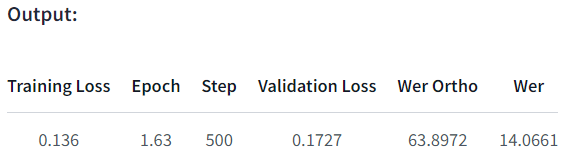